Comenzando cargando las librerías necesarias

In [11]:
import matplotlib.pyplot
import numpy
import pandas
import random
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree
import xgboost

A continuación definimos algunas funciones de utilidad y cargamos el conjunto de datos discretizado.

In [4]:
# Definición de función para discretizar variables por cuantiles
def DiscretizarPorCuantiles(datos, columnas, intervalos):
    datosNuevos = datos.copy()
    informacion = {}
    for columna in columnas:
        paso      = 1 / intervalos
        cuantiles = numpy.arange(0, 1.0 + paso, paso)
        etiquetas = list(map(str, numpy.arange(1, intervalos + 1)))

        (nuevosDatos, intervalosEtiquetas) = pandas.qcut(x=datos[columna], q=cuantiles, labels=etiquetas, retbins=True)
        datosNuevos[columna] = nuevosDatos
        informacion[columna] = { "cuantiles": cuantiles, "etiquetas": etiquetas, "intervalos": intervalosEtiquetas }
    return [datosNuevos, informacion ]

# Definición de función para calcular métricas a partir de un modelo
def CalcularMetricas(observaciones, predicciones):
    matriz_confusion = sklearn.metrics.confusion_matrix(observaciones, predicciones)
    metricas  = {
        "accuracy": sklearn.metrics.accuracy_score(observaciones, predicciones),
        "precision": sklearn.metrics.precision_score(observaciones, predicciones),
        "recall": sklearn.metrics.recall_score(observaciones, predicciones),
        "f1": sklearn.metrics.f1_score(observaciones, predicciones),
        "TP": matriz_confusion[1, 1],
        "FP": matriz_confusion[0, 1],
        "TN": matriz_confusion[0, 0],
        "FN": matriz_confusion[1, 0]        
    }
    return metricas    

# Lectura de set de datos discretizado
setDatosOriginal = pandas.read_csv(filepath_or_buffer = "input/SetDatosDiscretizado.csv", sep = "\t",
                                       na_values = "NA")
setDatosDiscretizado, informacion = DiscretizarPorCuantiles(datos=setDatosOriginal, columnas=['age','height','weight'], intervalos=10)

# Separo los features del data frame del target a aprender
atributos = setDatosDiscretizado.drop(columns = [ "id", "cardio" ])
objetivo  = setDatosDiscretizado['cardio']


Luego, separamos el conjunto de datos en conjunto de *desarrollo* y conjunto de *test*

In [5]:
# Separar en sets de desarrollo (entrenamiento + validacion) y testeo
atributosDesarrollo, atributosTest, objetivoDesarrollo, objetivoTest = \
    sklearn.model_selection.train_test_split(atributos, objetivo, train_size = 0.8, test_size = 0.2, random_state = 0)

# Separar el set de desarrollo en sets de entrenamiento y validacion
atributosEntrenamiento, atributosValidacion, objetivoEntrenamiento, objetivoValidacion = \
    sklearn.model_selection.train_test_split(atributosDesarrollo, objetivoDesarrollo,
                                             train_size = 0.8, test_size = 0.2, random_state = 0)

# 1. Clasificación utilizando *Random Forest*

In [6]:
clasificadorRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=6, random_state=0)
clasificadorRandomForest.fit(atributosDesarrollo, objetivoDesarrollo)  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Ahora calculamos métricas utilizando el conjunto de test

In [8]:
predicciones = clasificadorRandomForest.predict(atributosTest)
metricas     = CalcularMetricas(objetivoTest, predicciones)
print(metricas)

{'accuracy': 0.7297857142857143, 'precision': 0.7700754975978037, 'recall': 0.6475256095801472, 'f1': 0.7035034093581002, 'TP': 4488, 'FP': 1340, 'TN': 5729, 'FN': 2443}


Finalmente, graficamos la importancia de cada uno de los atributos a los efectos del ajuste según los resultados devueltos por el clasificador *Random Forest*.

/opt/anaconda3/envs/aprendizaje-automatico/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


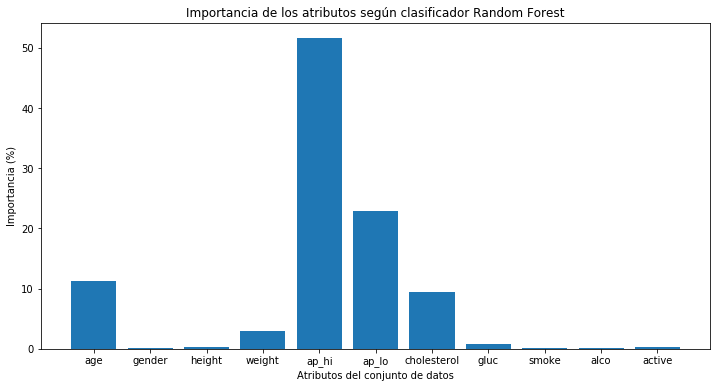

In [9]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * clasificadorRandomForest.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY)
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Random Forest')
figura.show()

# 2. Clasificación utilizando *Gradient Boosting* (XGBoost)

In [18]:
clasificadorXGBoost = xgboost.XGBClassifier(max_depth=7,
                                            min_child_weight=1,
                                            learning_rate=0.1,
                                            n_estimators=100,
                                            silent=True,
                                            objective='binary:logistic',
                                            gamma=0,
                                            max_delta_step=0,
                                            subsample=1,
                                            colsample_bytree=1,
                                            colsample_bylevel=1,
                                            reg_alpha=0,
                                            reg_lambda=0,
                                            scale_pos_weight=30,
                                            seed=0,
                                            missing=None)
clasificadorXGBoost.fit(atributosDesarrollo, objetivoDesarrollo)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields age, height, weight

age            category
gender            int64
height         category
weight         category
ap_hi             int64
ap_lo             int64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
dtype: object